In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [14]:
dados = pd.read_excel('datajpchaseemorgaco.xlsx')
dados

,DATE,OPEN,HIGH,LOW,CLOSE,ADJ PRICE,VOLUME
0,2000-01-03,49833332,50250000,48083332,48583332,24406227,12019200
1,2000-01-04,47083332,47458332,46125000,47250000,23870712,11723400
2,2000-01-05,46833332,48375000,46000000,46958332,23723372,8714550
3,2000-01-06,46750000,48625000,46500000,47625000,24060173,8369250
4,2000-01-07,48416668,49000000,47333332,48500000,24502220,6571950
...,...,...,...,...,...,...,...
5858,2023-04-17,139949997,140059998,137660004,139830002,139830002,16050500
5859,2023-04-18,140270004,141779999,139029999,141399994,141399994,13760100
5860,2023-04-19,141229996,141500000,140399994,141220001,141220001,9158100
5861,2023-04-20,139910004,141429993,139839996,140809998,140809998,10586200


Tratamento do dataset

In [15]:
dados = dados.drop(['DATE'], axis=1)

indices = [5860, 5861, 5862]

for indice in indices:
    dados = dados.drop(indice)
dados

,OPEN,HIGH,LOW,CLOSE,ADJ PRICE,VOLUME
0,49833332,50250000,48083332,48583332,24406227,12019200
1,47083332,47458332,46125000,47250000,23870712,11723400
2,46833332,48375000,46000000,46958332,23723372,8714550
3,46750000,48625000,46500000,47625000,24060173,8369250
4,48416668,49000000,47333332,48500000,24502220,6571950
...,...,...,...,...,...,...
5855,129179993,130429993,128059998,128500000,128500000,11821000
5856,128460007,129039993,126830002,128990005,128990005,12450200
5857,135149994,139119995,134899994,138729996,138729996,43896500
5858,139949997,140059998,137660004,139830002,139830002,16050500


In [16]:
dados.describe()

,OPEN,HIGH,LOW,CLOSE,ADJ PRICE,VOLUME
count,5.860000e+03,5.860000e+03,5.860000e+03,5.860000e+03,5.860000e+03,5.860000e+03
mean,6.437588e+07,6.509334e+07,6.364332e+07,6.437407e+07,5.146088e+07,2.033251e+07
std,3.637444e+07,3.664528e+07,3.610705e+07,3.637305e+07,3.831708e+07,1.887603e+07
min,1.537000e+07,1.635000e+07,1.496000e+07,1.545000e+07,8.618587e+06,1.347300e+06
25%,3.865750e+07,3.925000e+07,3.813625e+07,3.871000e+07,2.437436e+07,9.768400e+06
50%,4.784500e+07,4.843875e+07,4.731000e+07,4.780500e+07,3.157802e+07,1.383600e+07
75%,8.962750e+07,9.066250e+07,8.816500e+07,8.935250e+07,7.631319e+07,2.363190e+07
max,1.727100e+08,1.729600e+08,1.705400e+08,1.717800e+08,1.640157e+08,2.172942e+08


Análise de Multicolinearidade - Provável solução = Redução de dimensionalidade

In [47]:
colunas = ['OPEN', 'HIGH', 'LOW']
dados[colunas].corr()

,OPEN,HIGH,LOW
OPEN,1.000000,0.999779,0.999768
HIGH,0.999779,1.000000,0.999636
LOW,0.999768,0.999636,1.000000


Feature Engineering

In [41]:
colunas = ['OPEN', 'HIGH', 'LOW']
x_train = dados[colunas]
y_train = dados['CLOSE']

In [42]:
#Particionando a amostra em 4 quartis
num_iterations = 4
quartil_size = len(x_train) // num_iterations
partitions = [x_train[i:i+quartil_size] for i in range(0, len(x_train), quartil_size)]
target_partitions = [y_train[i:i+quartil_size] for i in range(0, len(y_train), quartil_size)]

Validação Cruzada

In [43]:
mse_scoretrain = []
mse_scoretest = []

for i in range(num_iterations):
    
    x_test, y_test = partitions[i], target_partitions[i]
    x_train = np.vstack(partitions[:i] + partitions[i+1:])
    y_train = np.concatenate(target_partitions[:i] + target_partitions[i+1:])
    
    #Conjunto de Treino
    reg = LinearRegression()
    reg.fit(x_train, y_train)
    y_predtrain = reg.predict(x_train)
    
    #Conjunto de teste
    y_pred = reg.predict(x_test)
    
    #Erros Quadráticos Médios
    msetrain = mean_squared_error(y_train, y_predtrain) #Erro Quadrático médio do Treino
    msetest = mean_squared_error(y_test, y_pred) #Erro Quadrático médio do Teste
    mse_scoretrain.append(msetrain)
    mse_scoretest.append(msetest)
    
    
    #Construção do modelo estatísico 
    X = x_train
    y = y_train
    X2 = sm.add_constant(X) #Adiciona costante ao modelo
    est = sm.OLS(y, X2) #Criando um mo delo
    est2 = est.fit() #Treinando o modelo estatístico

C:\Users\leona\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Users\leona\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Users\leona\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Users\leona\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LinearR

In [44]:
#Modelo ao fim da validação cruzada
print(est2.summary()) #OLS na 4ª iteração.
print("O modelo é: Fechamento = {:.5} + {:.5}*Open + {:.5}*High + {:.5}*Adj Price".format(reg.intercept_, 
                                                                                    reg.coef_[0], 
                                                                                    reg.coef_[1], 
                                                                                    reg.coef_[2]))
#Equação na 4ª Iteração

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.927e+06
Date:                Tue, 21 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:48:54   Log-Likelihood:                -62497.
No. Observations:                4395   AIC:                         1.250e+05
Df Residuals:                    4391   BIC:                         1.250e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.229e+04   2.13e+04     -1.513      0.1

Análise de métricas

In [45]:
print('Erros Quadrados de Treino: ', mse_scoretrain)
print('Erros Quadrados de Teste: ', mse_scoretest)
mse_scoretrain = pd.DataFrame(mse_scoretrain)
mse_scoretest = pd.DataFrame(mse_scoretest)

mean_msetrain = np.mean(mse_scoretrain)
mean_msetest = np.mean(mse_scoretest)
print('Média dos Erros Quadrados de Treino: ', mean_msetrain)
print('Média dos Erros Quadrados de Teste: ', mean_msetest)
variance = mse_scoretrain - mse_scoretest
print('Variância: ',variance.mean())
#Possuem Baixa Variância, além disso, Erros(Bias) baixo nos dois modelo. Logo, o modelo é ótimo.

Erros Quadrados de Treino:  [268991009650.24402, 249133126909.9653, 276524213942.2334, 131500276437.66928]
Erros Quadrados de Teste:  [119942853521.08658, 180236248369.31906, 97619445247.5325, 538458520330.58875]
Média dos Erros Quadrados de Treino:  231537156735.028
Média dos Erros Quadrados de Teste:  234064266867.1317
Variância:  0   -2.527110e+09
dtype: float64


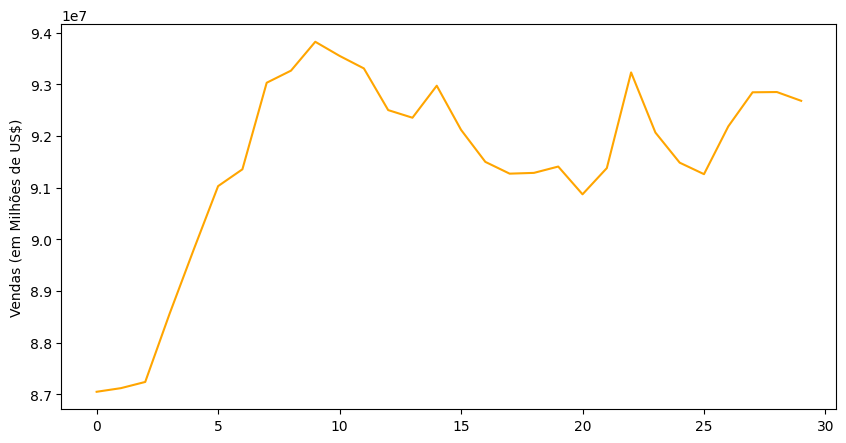

In [46]:
#Visualizando os 30 primeiros dias
y_pred = pd.DataFrame(y_pred)
y_pred30 = y_pred.head(30)

#Gráfico de linhas
plt.figure(figsize = (10,5))
plt.plot(y_pred30, c='orange')
plt.ylabel('Vendas (em Milhões de US$)')
plt.show()